# Anomaly Detection

To identify potential fraudulent transactions before transaction execution and reduce financial loss due to criminal activity.

## Datasets

The data source is retrieved from: https://www.kaggle.com/ntnu-testimon/paysim1<br/><br/>
The data fields in this data set are as follows:<br/>
- **stepMaps** - a unit of time in the real world. In this case 1 step is 1 hour of time
- **type** - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER
- **amount** - amount of the transaction in local currency
- **nameOrig** - customer who started the transaction
- **oldbalanceOrg** - initial balance before the transaction
- **newbalanceOrig** - customer's balance after the transaction
- **nameDest** - recipient ID of the transaction
- **oldbalanceDest** - initial recipient balance before the transaction
- **newbalanceDest** - recipient's balance after the transaction
- **isFraud** - identifies a fraudulent transaction (1) and non fraudulent (0)
- **isFlaggedFraud** - flags illegal attempts to transfer more than 200.000 in a single transaction

## Modeling Strategy

As a team we will break the data set into three segments:
- Train - 70% for training
- Test - 20% for testing
- Validation - 10%  for validation

Initially the team thought we should keep all the fields in the data set, as the data was being described to be ready "as-is".  We did conduct some exploratory analysis and attempted to find casual relationships.

After additional analysis, we determine that we should drop the fields <b>isFraud</b> and <b>isFlaggedFraud</b> as we are attempting to do an unsupervised training model.

## Model Selection
We are going to work thorugh a unsupervised model using Random Cut Forest.  Once we complete the analysis of this model, we will determine an appropriate supervised model to compare and contrast the two models.

## End Goal
Before transaction is committed / approved, automatically run data thorugh model.  Any transactions flagged as being fradulent would be automatically put on hold and flagged for manual review.

## References
[1](https://fin.plaid.com/articles/algorithmic-and-rules-based-fraud-models)

Imports, setup:

In [1]:
import boto3
import pandas as pd
from sagemaker import get_execution_role
import numpy as np  # linear algebra
import datetime
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
import seaborn as sns
sns.set_style("dark")
role = get_execution_role()


Load the CSV into the dataframe:

In [2]:
bucket='aws-ml-anomalydetection'
data_key = 'PS_20174392719_1491204439457_log.csv'
data_location = 's3://{}/{}'.format(bucket, data_key)

data = pd.read_csv(data_location)
print (data.head())

   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  


In [3]:
# what types are marked fraud?
list(data.loc[data.isFraud == 1].type.drop_duplicates().values)

['TRANSFER', 'CASH_OUT']

Drop the isFraud, isFlaggedFraud columns

In [4]:
data2 = data.drop(['isFraud','isFlaggedFraud'], axis='columns')

Review progress, data shape:

In [5]:
print(data2.head())
data2.shape

   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  
0  M1979787155             0.0             0.0  
1  M2044282225             0.0             0.0  
2   C553264065             0.0             0.0  
3    C38997010         21182.0             0.0  
4  M1230701703             0.0             0.0  


(6362620, 9)

In [6]:
# any nulls anywhere...?
data2.isnull().values.any()

False

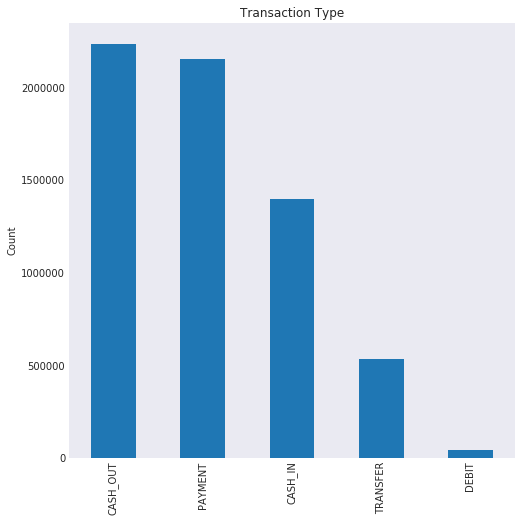

In [7]:
# simple counts of transaction type...
f, ax = plt.subplots(1, 1, figsize=(8, 8))
data2.type.value_counts().plot(kind='bar', title="Transaction Type", ax=ax, figsize=(8,8), colormap='tab10')
ax.set_ylabel("Count")
plt.show()

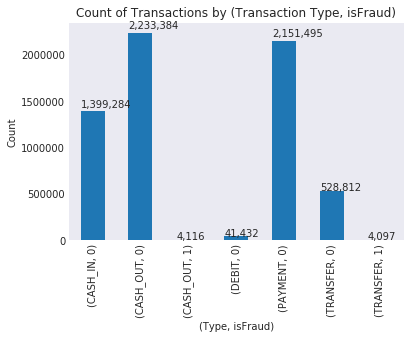

In [8]:
# chart of isFraud values by type...
ax = data.groupby(['type', 'isFraud']).size().plot(kind='bar', colormap='tab10')
ax.set_title("Count of Transactions by (Transaction Type, isFraud)")
ax.set_xlabel("(Type, isFraud)")
ax.set_ylabel("Count")
for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()*1.02))

Text(0,0.5,'Count')

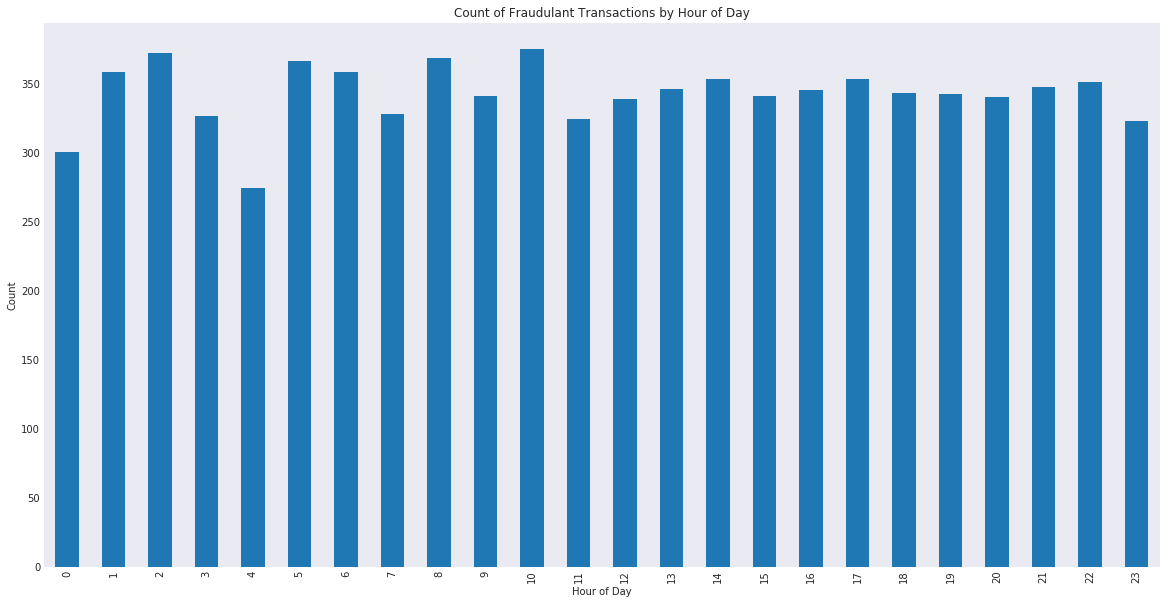

In [9]:
# counts of isFraud by hour of day (1 through 24)
data["hourOfDay"] = data.step % 24
ax = data[data.isFraud==1].groupby(['hourOfDay']).size().plot(kind='bar', colormap='tab10', figsize=(20,10))
ax.set_title("Count of Fraudulant Transactions by Hour of Day")
ax.set_xlabel("Hour of Day")
ax.set_ylabel("Count")

Text(0,0.5,'Count')

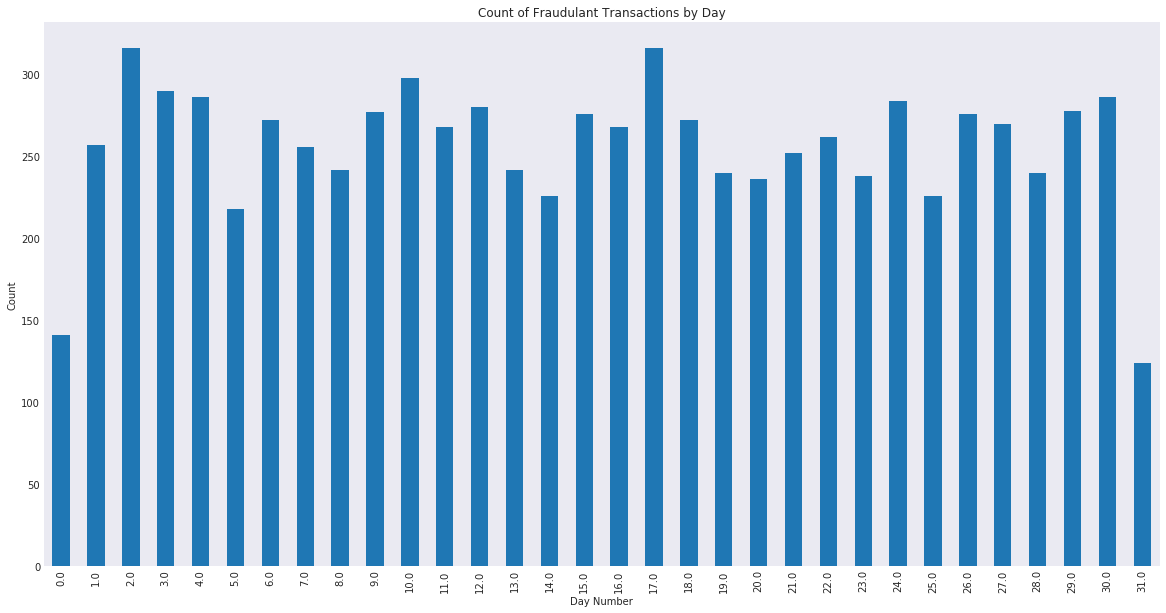

In [10]:
# counts by "day"... we don't know what day it is (e.g. day of week... can we infer anything? ... doiesn't look like it)
data["DayNumber"] = round(data.step / 24)
ax = data[data.isFraud==1].groupby(['DayNumber']).size().plot(kind='bar', colormap='tab10', figsize=(20,10))
ax.set_title("Count of Fraudulant Transactions by Day")
ax.set_xlabel("Day Number")
ax.set_ylabel("Count")